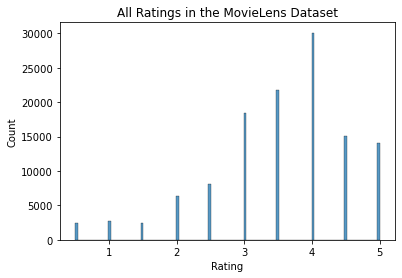

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('data.csv')

sns.histplot(data['Rating'], kde=False)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('All Ratings in the MovieLens Dataset')
plt.show()


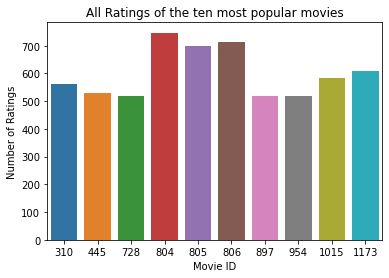

In [2]:
data_grouped = data.groupby('Movie ID').agg({'Rating': 'count'}).reset_index()
data_grouped = data_grouped.sort_values(by='Rating', ascending=False).head(10)

sns.barplot(x='Movie ID', y='Rating', data=data_grouped)
plt.xlabel('Movie ID')
plt.ylabel('Number of Ratings')
plt.title('All Ratings of the ten most popular movies')
plt.show()



In [3]:
#data_grouped = data.groupby('Movie ID').agg({'Rating': 'count'}).reset_index()
#data_grouped = data_grouped.sort_values(by='Rating', ascending=False).head(10)

#movies = pd.read_csv('movies.csv')
#data_grouped = data_grouped.merge(movies[['Movie ID', 'Movie Title']], on='Movie ID')

#sns.barplot(x='Movie Title', y='Rating', data=data_grouped)
#plt.xlabel('Movie Title')
#plt.ylabel('Number of Ratings')
#plt.title('All Ratings of the ten most popular movies')
#plt.xticks(rotation=90)
#plt.show()


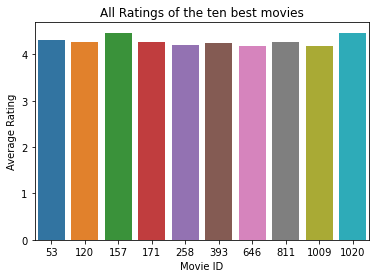

In [4]:
data_grouped = data.groupby('Movie ID').agg({'Rating': 'mean'}).reset_index()
data_grouped = data_grouped.sort_values(by='Rating', ascending=False).head(10)

sns.barplot(x='Movie ID', y='Rating', data=data_grouped)
plt.xlabel('Movie ID')
plt.ylabel('Average Rating')
plt.title('All Ratings of the ten best movies')
plt.show()


In [11]:
#data_grouped = data.groupby('Movie ID').agg({'Rating': 'mean'}).reset_index()
#data_grouped = data_grouped.sort_values(by='Rating', ascending=False).head(10)

#movies = pd.read_csv('movies.csv')
#data_grouped = data_grouped.merge(movies[['Movie ID', 'Movie Title']], on='Movie ID')

#sns.barplot(x='Movie Title', y='Rating', data=data_grouped)
#plt.xlabel('Movie Title')
#plt.ylabel('Average Rating')
#plt.title('All Ratings of the ten best movies')
#plt.xticks(rotation=90)
#plt.show()


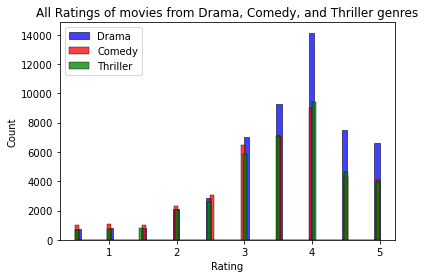

In [5]:
movies = pd.read_csv('movies.csv')

# Select three genres of your choice
genre1 = 'Drama'
genre2 = 'Comedy'
genre3 = 'Thriller'

data_grouped1 = data[data['Movie ID'].isin(movies[movies[genre1] == 1]['Movie ID'])]
data_grouped2 = data[data['Movie ID'].isin(movies[movies[genre2] == 1]['Movie ID'])]
data_grouped3 = data[data['Movie ID'].isin(movies[movies[genre3] == 1]['Movie ID'])]

sns.histplot(data_grouped1['Rating'], kde=False, label=genre1, color='blue')
sns.histplot(data_grouped2['Rating'], kde=False, label=genre2, color='red')
sns.histplot(data_grouped3['Rating'], kde=False, label=genre3, color='green')

plt.xlabel('Rating')
plt.ylabel('Count')
plt.title(f'All Ratings of movies from {genre1}, {genre2}, and {genre3} genres')
plt.legend()
plt.show()


# Method 1: Code from HW5

In [43]:
def grad_U(Ui, Yij, Vj, reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    grad_Ui = eta * (reg * Ui - Vj*(Yij - np.dot(Ui, Vj)))
                     
    return grad_Ui
                     

def grad_V(Vj, Yij, Ui, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    grad_Vj = eta * (reg * Vj - Ui*(Yij - np.dot(Ui, Vj)))
    
    return grad_Vj


def get_err(U, V, Y, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    err = 0
    for i, j, y_ij in Y:
        err += 0.5*(y_ij - np.dot(U[i], V[j]))**2
    return (err) / len(Y)


def train_model(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV^T)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """
    U = np.random.uniform(-0.5, 0.5, (M, K))
    V = np.random.uniform(-0.5, 0.5, (N, K))
    err = get_err(U, V, Y)
    delta_err = None
    init_err = err
    for epoch in range(max_epochs):
        err_next = get_err(U, V, Y)
        delta_err = err - err_next
        if abs(delta_err / init_err) < eps and epoch != 0:
            break
        err = err_next
        indices = np.random.permutation(len(Y))
        for index in indices:
            i, j, y_ij = Y[index]
            grad_u = grad_U(U[i], y_ij, V[j], reg, eta)
            grad_v = grad_V(V[j], y_ij, U[i], reg, eta)
            U[i] -= grad_u
            V[j] -= grad_v
    return U, V, get_err(U, V, Y)

In [44]:
import numpy as np
import pandas as pd

# Load the data
data = pd.read_csv('data.csv')

# Split the data into training and test sets
train_data = data[:109351]
test_data = data[109351:]

# Create a user-item matrix from the data
n_users = data['User ID'].nunique()
n_items = data['Movie ID'].nunique()

# Initialize the user-item matrix with zeros
Y = []
for row in train_data.itertuples():
    Y.append((row[1], row[2], row[3]))

# Define the number of latent features
K = 20

# Define the regularization parameter
reg = 0.1

# Define the learning rate
eta = 0.01

# Train the model
U, V, err = train_model(n_users, n_items, K, eta, reg, Y)




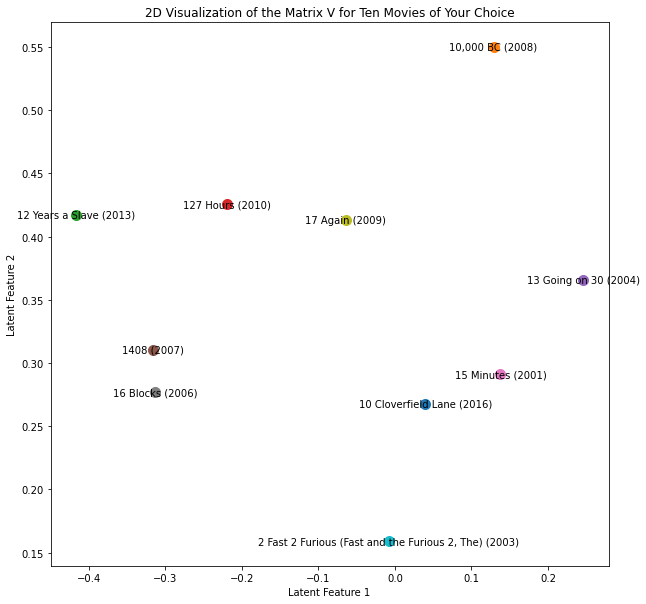

In [47]:
# Choose ten movies of your choice
movie_ids = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
selected_movies = movies[movies['Movie ID'].isin(movie_ids)]

plt.figure(figsize=(10, 10))
# Plot the 2D visualization of the matrix V for the selected movies
for i, movie in enumerate(selected_movies['Movie Title']):
    plt.scatter(V[selected_movies['Movie ID'].values[i], 0], V[selected_movies['Movie ID'].values[i], 1], s=100)
    plt.text(V[selected_movies['Movie ID'].values[i], 0], V[selected_movies['Movie ID'].values[i], 1], movie, ha='center', va='center', fontsize=10)
plt.xlabel('Latent Feature 1')
plt.ylabel('Latent Feature 2')
plt.title('2D Visualization of the Matrix V for Ten Movies of Your Choice')
plt.show()

# Method 2: Code with bias

In [48]:
import numpy as np
import pandas as pd

# Load the data
data = pd.read_csv('data.csv')

# Split the data into training and test sets
train_data = data[:109351]
test_data = data[109351:]

# Create a user-item matrix from the data
n_users = data['User ID'].nunique()
n_items = data['Movie ID'].nunique()

# Initialize the user-item matrix with zeros
Y = np.zeros((n_users, n_items))
for row in train_data.itertuples():
    Y[row[1], row[2]] = row[3]

# Define the number of latent features
k = 20

# Define the global average rating
global_mean = np.mean(Y[np.where(Y != 0)])

# Initialize the user and item biases
user_biases = np.zeros(n_users)
item_biases = np.zeros(n_items)

# Define the regularization parameters
lambda_user = 0.1
lambda_item = 0.1

# Initialize the user and item latent feature matrices with random values
np.random.seed(0)
U = np.random.normal(scale=1./k, size=(n_users, k))
V = np.random.normal(scale=1./k, size=(n_items, k))

# Define the number of iterations
num_iterations = 50

# Define the learning rate
learning_rate = 0.01

# Train the model using stochastic gradient descent
for i in range(num_iterations):
    for j in range(Y.shape[0]):
        for k in range(Y.shape[1]):
            if Y[j, k] > 0:
                e = Y[j, k] - (global_mean + user_biases[j] + item_biases[k] + np.dot(U[j, :], V[k, :].T))
                user_biases[j] += learning_rate * (e - lambda_user * user_biases[j])
                item_biases[k] += learning_rate * (e - lambda_item * item_biases[k])
                U[j, :] += learning_rate * (e * V[k, :] - lambda_user * U[j, :])
                V[k, :] += learning_rate * (e * U[j, :] - lambda_item * V[k, :])



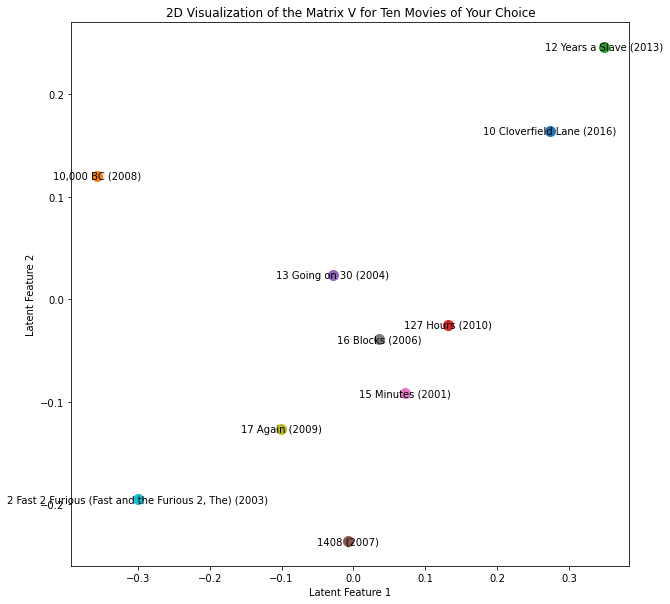

In [49]:
# Choose ten movies of your choice
movie_ids = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
selected_movies = movies[movies['Movie ID'].isin(movie_ids)]

# Plot the 2D visualization of the matrix V for the selected movies
plt.figure(figsize=(10, 10))
for i, movie in enumerate(selected_movies['Movie Title']):
    plt.scatter(V[selected_movies['Movie ID'].values[i], 0], V[selected_movies['Movie ID'].values[i], 1], s=100)
    plt.text(V[selected_movies['Movie ID'].values[i], 0], V[selected_movies['Movie ID'].values[i], 1], movie, ha='center', va='center', fontsize=10)
plt.xlabel('Latent Feature 1')
plt.ylabel('Latent Feature 2')
plt.title('2D Visualization of the Matrix V for Ten Movies of Your Choice')
plt.show()


# Code Part 3: Off the shelf

In [7]:
!pip install scikit-surprise

  Using cached scikit-surprise-1.1.3.tar.gz (771 kB)
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp38-cp38-win_amd64.whl size=1139692 sha256=4336d208c71a763d48579e5069a8ecf80a9f3fdb86c547b9cad86503a4008c32
  Stored in directory: c:\users\18133\appdata\local\pip\cache\wheels\af\db\86\2c18183a80ba05da35bf0fb7417aac5cddbd93bcb1b92fd3ea
Successfully built scikit-surprise


In [67]:
from surprise import SVD
from surprise import Dataset
from surprise import Reader

# Load the data
data = pd.read_csv('data.csv')

# Split the data into training and test sets
train_data = data[:109351]
test_data = data[109351:]

# Define the reader object
reader = Reader(rating_scale=(0.5, 5.0))

# Load the data into the Surprise library format
train_dataset = Dataset.load_from_df(train_data[['User ID', 'Movie ID', 'Rating']], reader)
test_dataset = Dataset.load_from_df(test_data[['User ID', 'Movie ID', 'Rating']], reader)

# Fit the SVD model to the training data
algo = SVD()
algo.fit(train_dataset.build_full_trainset())

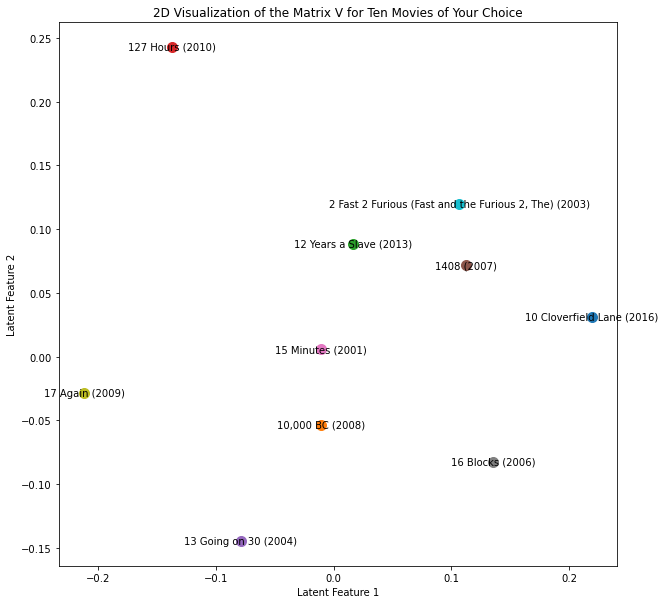

In [68]:
import matplotlib.pyplot as plt

# Load the movie data
movies = pd.read_csv('movies.csv')

# Choose ten movies of your choice
movie_ids = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
selected_movies = movies[movies['Movie ID'].isin(movie_ids)]

# Get the latent feature matrix for the movies
V = algo.qi

# Plot the 2D visualization of the matrix V for the selected movies
plt.figure(figsize=(10, 10))
for i, movie in enumerate(selected_movies['Movie Title']):
    plt.scatter(V[selected_movies['Movie ID'].values[i], 0], V[selected_movies['Movie ID'].values[i], 1], s=100)
    plt.text(V[selected_movies['Movie ID'].values[i], 0], V[selected_movies['Movie ID'].values[i], 1], movie, ha='center', va='center', fontsize=10)
plt.xlabel('Latent Feature 1')
plt.ylabel('Latent Feature 2')
plt.title('2D Visualization of the Matrix V for Ten Movies of Your Choice')
plt.show()
